In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random
from datetime import datetime
import pandas as pd
from gekko import GEKKO
df = pd.read_csv('Parsed.csv')
BG_dat = df['Blood Glucose (mg/dL)'].values
for i in range(len(BG_dat)):
    if i==0:
        BG_dat[i] = BG_dat[i+1]
    elif np.isnan(BG_dat[i]):
        BG_dat[i] = BG_dat[i-1]
In = int(1440*20+540)  #index for start time --1440 minutes per day, 540 per 9 hour period

# For m in [mhe, sim]
#minutes run
N = int(180) #minutes in 3 hours
h = int(3) #number of time horizons
H = int(N*h)
dt = 1  # (min) timespacing
m = GEKKO()

# TODO Find optimal control horizon to account for disturbances especially
m.time = np.linspace(0, N, N+1)  # Three hour moving horizon

# Params
bg = m.Param(291.0, name='bg')  # (mg/dL) Basal Blood Glucose
p1 = m.Param(3.17e-2, name='p1')   # (1/min)
p2 = m.Param(1.23e-2, name='p2')   # (1/min)
# si = m.Param(2.9e-2)    # (1/min * (mL/micro-U))
ke = m.Param(9.0e-2)    # (1/min) Insulin elimination from plasma
kabs = m.Param(1.2e-2)  # (1/min) t max,G inverse
kemp = m.Param(1.8e-1)  # (1/min) t max,I inverse
f = m.Param(8.00e-1)    # (L)
vi = m.Param(12.0)      # (L)     Insulin distribution volume
vg = m.Param(12.0)      # (L)     Glucose distibution volume

final = np.zeros_like(m.time)
final[-1] = 1
fin = m.Param(final)

# FV
# TODO implement good bounds on these
# TODO Bounds on possible levels

si = m.FV(2.9e-2, lb=0.01, ub=1)    # (1/min * (mL/micro-U))
D  = m.MV(0, lb=0, ub=4000)      # Disturbance (mmol/L min)
# storage arrays
si_ = np.zeros(H)
D_  = np.zeros(H)
G_  = np.zeros(H)
Ob_ = np.zeros(H)
U_  = np.zeros(H)

# Vars
# TODO: Initial Values
G = m.CV(BG_dat[In], fixed_initial=True, lb=10, ub=400)    # (mg/dL) Blood Glucose
X = m.Var(1,)      # (μu/ml) Remote Insulin
I = m.Var(1,)      # (μu/ml) Plasma Insulin
U = m.MV(.024,fixed_initial=True, lb=0)       # (mU/min) Insulin Delivery
GG = m.Var(1,)     # (mg/dL) Gut insulin

S1 = m.Var()     # Subcutaneous storage
S2 = m.Var()     # Intermediate 2

# obj = m.Var(0)

# Equations
m.Equations([
    G.dt()/dt == -p1 * (G-bg) - si * X * G + f * kabs / vg * GG + f / vg * D,  # Dynamic Insulin Rate
    X.dt()/dt == p2 * (I - X),                                                 # Remote Insulin dynamics
    I.dt()/dt == -ke * I + U,                                                  # Plasma Insulin Concentration
    S1.dt()/dt == U - kemp * S1,                                               # Dynamic Model
    S2.dt()/dt == -kemp * (S2 - S1),                                           # Dynamic Model
    GG.dt()/dt == kemp * S2 - kabs * GG,
#     obj.dt() == m.if3(G-lb, -1 * lm, m.if3(ub-g, -1, 1.0 - m.tanh(m.abs3((G-target)/slope)*0.1)**2)) # m.integral(print(reward_func(G)[0]))
])

## Tuning
si.STATUS = 1; si.FSTATUS = 0
D.STATUS  = 1; D.FSTATUS  = 0
D.DCOST=.001


G.STATUS  = 0; G.FSTATUS  = 1
U.STATUS  = 0; U.FSTATUS  = 1

## Global options
m.options.IMODE   = 5
m.options.EV_TYPE = 2

# m.Maximize(obj * fin)MHE

In [5]:
df = pd.read_csv('Parsed.csv')
df_dense = df.dropna()
En = int(In+H)
i=1
for date, time, glucose, insulin in df.iloc[In:En].itertuples(index=False):
    if not np.isnan(glucose):
        G.MEAS = glucose
#     else:
#         G.MEAS = G.value

    U.MEAS = insulin
    # solve with MHE
#     print(G,U)
    m.solve(disp=False)
    # Store MHE values for basal glucose rate and disturbances
#     print(f'{si.NEWVAL=}')
#     print(f'{D.NEWVAL=}')
#     print(f'{G.MODEL=} vs {glucose}')
#     print(f'{U.NEWVAL=}')
    print(f'{m.options.OBJFCNVAL}\n')
    si_[i] = si.NEWVAL
    D_[i]  = D.NEWVAL
    U_[i]  = U.NEWVAL
    G_[i]  = G.MODEL
    Ob_[i] = m.options.OBJFCNVAL
    i += 1

14.630479069

61.488687718

51.367793922

53.307269797

53.315148538

53.146388608

69.103018522

65.997937497

66.21671256

66.056114624

65.872744976

65.695196132

65.513444405

65.329304942

65.143901286

64.957479098

64.770094886

64.581793497

64.39262186

64.202620933

64.011822966

63.820252415

63.627927366

63.434860477

63.241059992

63.046530427

451.18691822

383.68838456

396.5772412

396.71013299

395.46907637

458.38641245

445.64268493

446.09106693

444.97239429

443.74899005

442.54742853

441.34435268

440.13092728

438.90685785

437.67306041

498.21549404

486.42244977

487.43725043

486.29704881

484.85591514

628.68246096

600.95820924

603.98884012

602.74321666

600.91838805

798.1009812

760.40221071

764.33072974

762.75822325

760.44185739

858.9196111

838.82166956

839.51499285

837.2938835

834.7548824

869.17979615

859.93010071

858.27566016

855.70863341

853.06317232

854.83302919

851.30016578

848.65384915

845.94811591

843.23480893

840.50958605


IndexError: index 540 is out of bounds for axis 0 with size 540

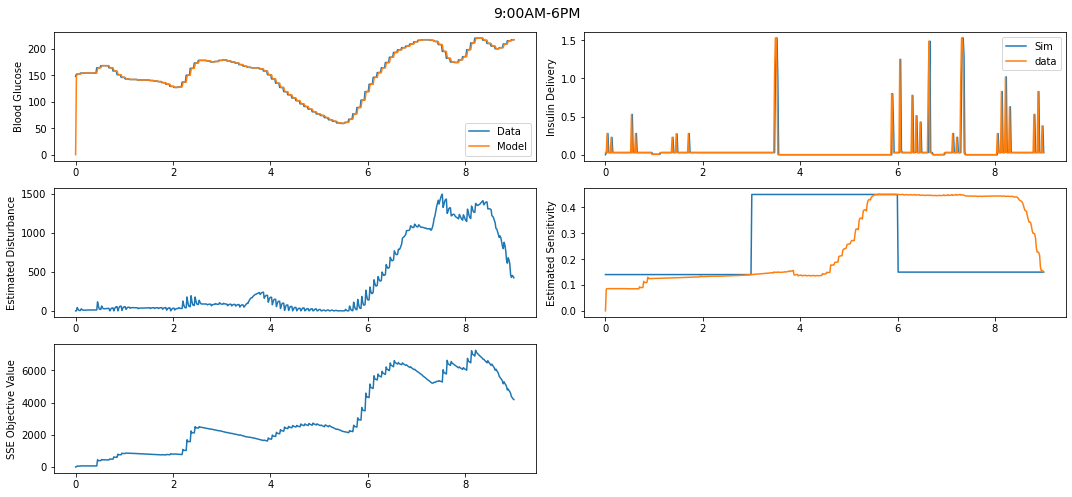

In [8]:
t_= np.linspace(0,1,N*h)*m.time[-1]*h/60
BG_dat = df['Blood Glucose (mg/dL)'].values
for i in range(len(BG_dat)):
    if i==0:
        BG_dat[i] = BG_dat[i+1]
    elif np.isnan(BG_dat[i]):
        BG_dat[i] = BG_dat[i-1]

plt.figure(figsize=(15,7))
fig = plt.gcf()
fig.suptitle("9:00AM-6PM", fontsize=14)
plt.subplot(321)
plt.plot(t_, BG_dat[In:En], label='Data')
plt.plot(t_,G_, label='Model')
plt.ylabel('Blood Glucose')
plt.legend()

plt.subplot(322)
# plt.plot(m.time,I)
# plt.plot(m.time,X)
# plt.plot(m.time,GG)
plt.plot(t_,U_,label='Sim')
plt.plot(t_,df['Insulin Delivery (IU) '][In:En], label='data')
plt.ylabel('Insulin Delivery')
plt.legend()

plt.subplot(323)
plt.plot(t_,D_)
plt.ylabel('Estimated Disturbance')

plt.subplot(324)
s = np.zeros_like(si_)
s[:180] = si_[180]
s[180:360] = si_[360]
s[360:] = si_[-1]
plt.plot(t_,s)
plt.plot(t_,si_)
plt.ylabel('Estimated Sensitivity')

plt.subplot(325)
plt.plot(t_,Ob_)
plt.ylabel('SSE Objective Value')
plt.tight_layout()

plt.savefig('"9:00AM-6PM_DAY4".png')

In [ ]:
t0 = np.linspace(0,1,n)*m.time[-1]*h
plt.plot(t_,G_)
plt.plot(t0, BG[:n], label='Data')
T = df['Time']
Tn = np.zeros_like(T)
for i in range(len(T)):
    pt = datetime.strptime(T[i],'%H:%M:%S')
    A  = pt.minute+pt.hour*60
    Tn[i] = A
print(len(Tn))
df.columns


In [ ]:
plt.plot(t_,si_)
plt.plot((360+m.time)/60,si)

In [ ]:
BG[540]

In [ ]:
En